In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [2]:
# Ruta raíz donde están las carpetas kos01 a kos50
ruta_base = "Imagenes_defectos"

def cargar_datos(ruta_base, img_size=(224, 224)):
    imagenes = []
    etiquetas = []

    # Recorrer las carpetas kos01 a kos50
    for carpeta in sorted(os.listdir(ruta_base)):
        ruta_carpeta = os.path.join(ruta_base, carpeta)
        if os.path.isdir(ruta_carpeta):
            # Procesar cada archivo en la carpeta
            for archivo in sorted(os.listdir(ruta_carpeta)):
                if archivo.endswith(".jpg"):
                    # Leer la imagen
                    ruta_imagen = os.path.join(ruta_carpeta, archivo)
                    imagen = cv2.imread(ruta_imagen)
                    imagen = cv2.resize(imagen, img_size)  # Redimensionar a 224x224
                    imagen = imagen / 255.0  # Normalizar

                    # Leer la máscara correspondiente
                    nombre_mascara = archivo.replace(".jpg", "_label.bmp")
                    ruta_mascara = os.path.join(ruta_carpeta, nombre_mascara)
                    if os.path.exists(ruta_mascara):
                        mascara = cv2.imread(ruta_mascara, cv2.IMREAD_GRAYSCALE)
                        mascara = cv2.resize(mascara, img_size)

                        # Convertir la máscara en etiqueta binaria
                        etiqueta = 1 if np.any(mascara > 0) else 0  # NOK = 1, OK = 0

                        imagenes.append(imagen)
                        etiquetas.append(etiqueta)

    # Convertir listas en arrays de NumPy
    imagenes = np.array(imagenes, dtype=np.float32)
    etiquetas = np.array(etiquetas, dtype=np.int32)
    return imagenes, etiquetas

# Cargar las imágenes y etiquetas
imagenes, etiquetas = cargar_datos(ruta_base)

# Verificar balance de clases
unique, counts = np.unique(etiquetas, return_counts=True)
print(f"Distribución de clases: {dict(zip(unique, counts))}")

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes, etiquetas, test_size=0.2, random_state=42)

# Convertir etiquetas a categóricas
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# Aumento de datos para la clase minoritaria (NOK)
def aumentar_clase_minoritaria(X_train, y_train, img_size=(224, 224)):
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

    # Filtrar imágenes de la clase minoritaria (NOK)
    X_min = X_train[y_train == 1]
    y_min = y_train[y_train == 1]

    # Generar imágenes aumentadas
    X_augmented = []
    y_augmented = []
    for img in X_min:
        img = img.reshape((1, *img_size, 3))  # Expandir dimensión para usar con datagen
        aug_iter = datagen.flow(img, batch_size=1)
        for _ in range(5):  # Generar 10 imágenes aumentadas por imagen original
            aug_img = next(aug_iter)[0]
            X_augmented.append(aug_img)
            y_augmented.append(1)

    # Concatenar los datos aumentados con los originales
    X_train_aug = np.concatenate([X_train, np.array(X_augmented)])
    y_train_aug = np.concatenate([y_train, np.array(y_augmented)])

    return X_train_aug, y_train_aug

# Aumentar los datos de la clase minoritaria
X_train_aug, y_train_aug = aumentar_clase_minoritaria(X_train, y_train)

# Calcular pesos de las clases
unique, counts = np.unique(y_train_aug, return_counts=True)
class_weights = {0: 1.0, 1: max(2.0, counts[0] / counts[1])}
print(f"Pesos de las clases: {class_weights}")


Distribución de clases: {0: 347, 1: 52}
Pesos de las clases: {0: 1.0, 1: 2.0}


In [3]:
# Crear modelo EfficientNet
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights="imagenet")

# Descongelar algunas capas del modelo base
for layer in base_model.layers[-20:]:  # Descongelar las últimas 20 capas
    layer.trainable = True

# Definir el modelo
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),  # Incrementar dropout para regularización
    Dense(2, activation="softmax")  # Clasificación binaria
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001),  # Reducir tasa de aprendizaje
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint("efficientnet_model.h5", save_best_only=True, monitor="val_loss")

# Entrenar el modelo con datos aumentados
history = model.fit(
    X_train_aug, to_categorical(y_train_aug, num_classes=2),
    validation_data=(X_test, y_test_cat),
    epochs=10,
    batch_size=32,
    class_weight=class_weights,  # Aplicar pesos de clase
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Evaluar el modelo
eval_result = model.evaluate(X_test, y_test_cat)
print(f"\nEvaluación del modelo: Loss={eval_result[0]}, Accuracy={eval_result[1]}")

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5985 - loss: 0.8741

17/17 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.6053 - loss: 0.8636 - val_accuracy: 0.1125 - val_loss: 0.9276 - learning_rate: 1.0000e-04
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - accuracy: 0.9173 - loss: 0.3583 - val_accuracy: 0.1125 - val_loss: 0.9803 - learning_rate: 1.0000e-04
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9427 - loss: 0.2507
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
17/17 ━━━━━━━━━━━━━━━━━━━━ 66s 4s/step - accuracy: 0.9429 - loss: 0.2498 - val_accuracy: 0.1125 - val_loss: 0.9600 - learning_rate: 1.0000e-04
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - accuracy: 0.9804 - loss: 0.1535 - val_accuracy: 0.1125 - val_loss: 0.9313 - learning_rate: 5.0000e-05
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9773 - loss: 0.1382
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
17/17 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.9779 - loss: 0.1373 - val_accuracy

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Total imágenes predichas como OK: 0
Total imágenes predichas como NOK: 80
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 472ms/step


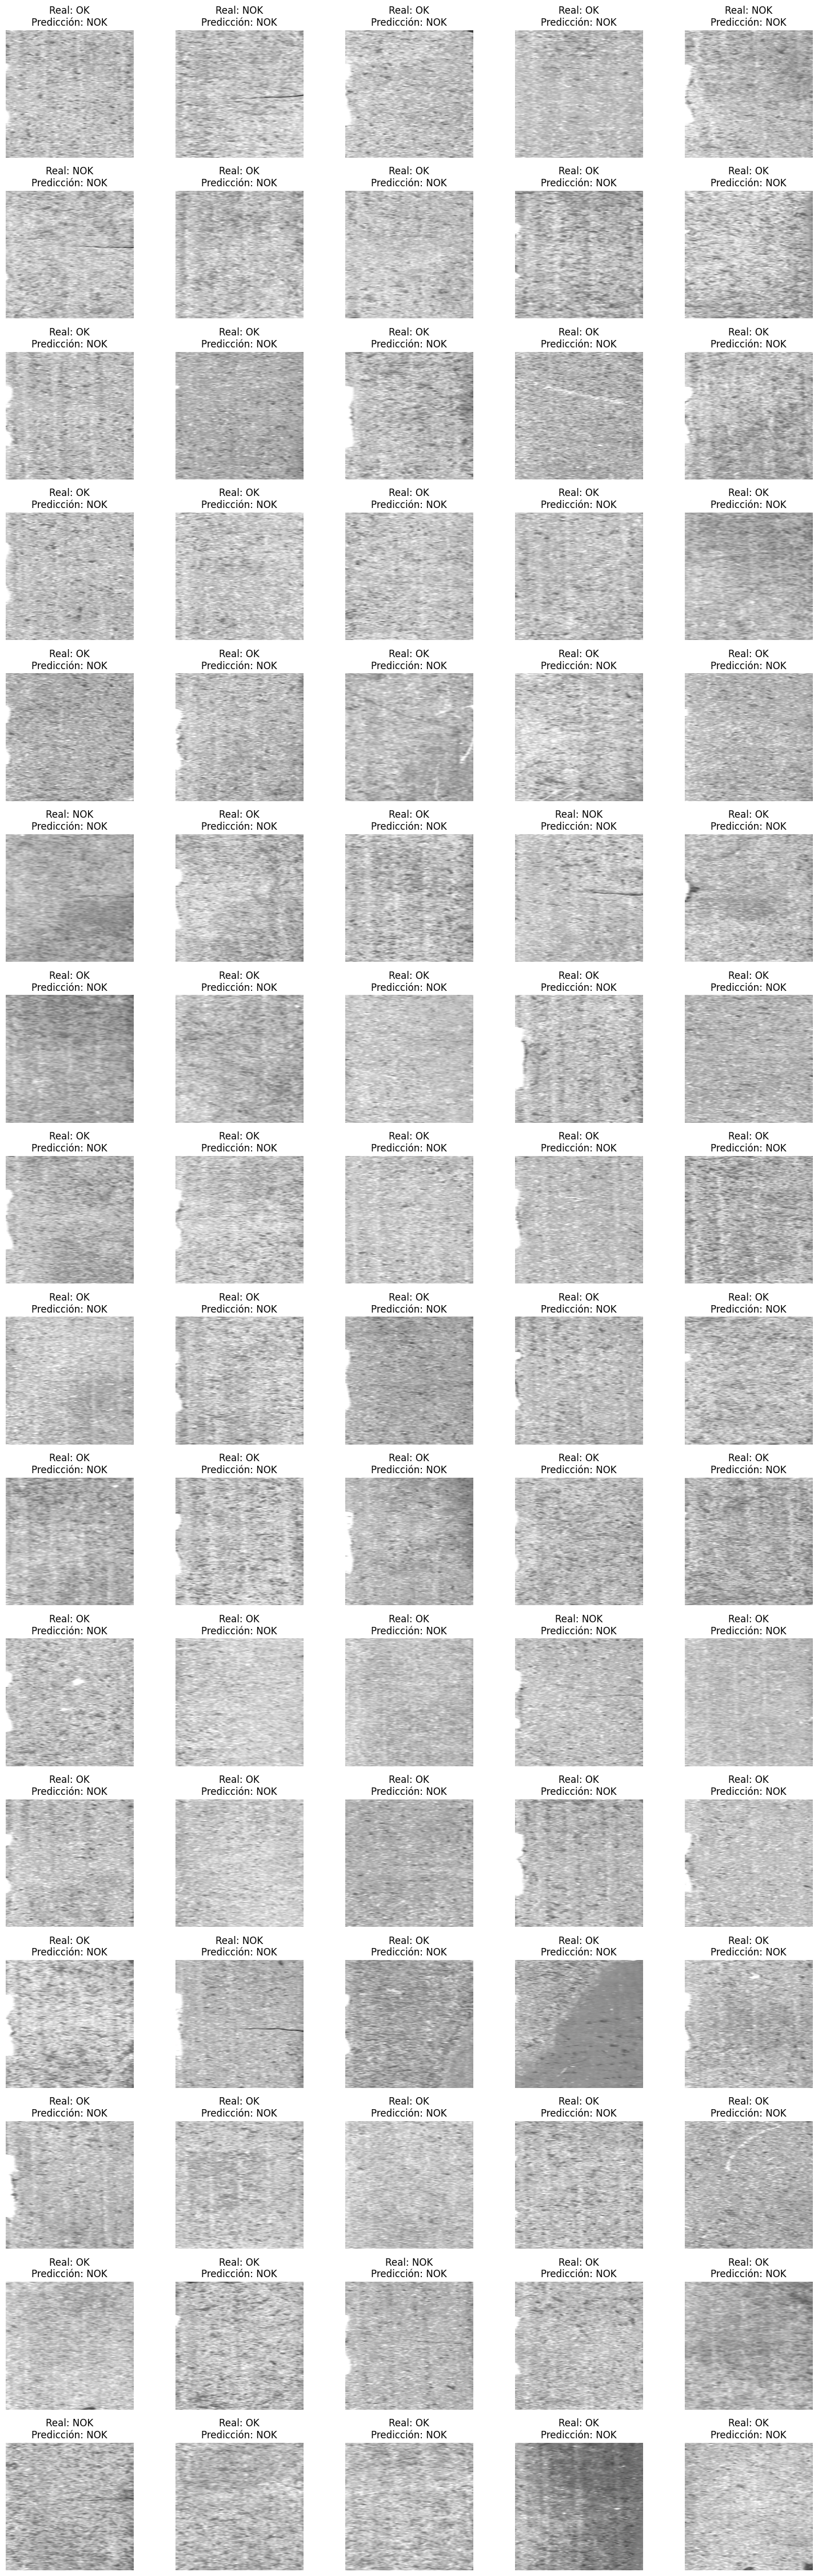

In [4]:
# Contar predicciones como OK y NOK
def contar_clasificaciones(model, X_test):
    predicciones = model.predict(X_test)
    predicciones_clase = np.argmax(predicciones, axis=1)
    ok_count = np.sum(predicciones_clase == 0)
    nok_count = np.sum(predicciones_clase == 1)

    print(f"Total imágenes predichas como OK: {ok_count}")
    print(f"Total imágenes predichas como NOK: {nok_count}")

# Llamar a la función para contar clasificaciones
contar_clasificaciones(model, X_test)

# Visualizar clasificaciones en todas las imágenes de prueba
def visualizar_todas_clasificaciones(model, X_test, y_test):
    predicciones = model.predict(X_test)
    predicciones_clase = np.argmax(predicciones, axis=1)

    plt.figure(figsize=(15, len(X_test) // 5 * 3))  # Ajustar tamaño dinámicamente
    for i in range(len(X_test)):
        imagen = X_test[i]
        etiqueta_real = "NOK" if y_test[i] == 1 else "OK"
        etiqueta_predicha = "NOK" if predicciones_clase[i] == 1 else "OK"

        plt.subplot(len(X_test) // 5 + 1, 5, i + 1)
        plt.imshow(imagen)
        plt.title(f"Real: {etiqueta_real}\nPredicción: {etiqueta_predicha}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Llamar a la función para visualizar todas las imágenes
visualizar_todas_clasificaciones(model, X_test, y_test)